In [1]:
#import libraries
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import warnings
from matplotlib import pyplot as plt
import seaborn as sns

from scipy import stats
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, MaxPooling2D
from keras.layers import Conv2D, MaxPooling2D
%matplotlib inline
warnings.simplefilter(action='ignore', category=FutureWarning)

r_seed = 42
np.random.seed(r_seed)
tf.random.set_seed(r_seed)

In [2]:
columns=['user','activity','time','x','y','z']

directory = r'E:\Advanced Decision Making\data\wisdm-dataset\raw'

data_all = pd.DataFrame(data=None,columns=columns)
             
for dir1 in os.listdir(directory):
    directory1 = os.path.join(directory,dir1)
    
    for dir2 in os.listdir(directory1):
        directory2 = os.path.join(directory1,dir2)
        
        for filename in os.listdir(directory2):
            f = os.path.join(directory2,filename)
            df = pd.read_csv(f, sep=',',header=None)  
            temp=pd.DataFrame(data=df.values, columns=columns)
            data_all=pd.concat([data_all,temp])

In [3]:
data_all['z'] = data_all['z'].str.replace(';','')
data_all['activity'].value_counts()
data_all['x']=data_all['x'].astype('float')
data_all['y']=data_all['y'].astype('float')
data_all['z']=data_all['z'].astype('float')


In [4]:
data_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15630426 entries, 0 to 66555
Data columns (total 6 columns):
 #   Column    Dtype  
---  ------    -----  
 0   user      object 
 1   activity  object 
 2   time      object 
 3   x         float64
 4   y         float64
 5   z         float64
dtypes: float64(3), object(3)
memory usage: 834.8+ MB


In [5]:
activities = data_all['activity'].value_counts().index
data_all = data_all.drop(['user', 'time'], axis=1)

df_a = data_all[data_all['activity']=='A'].head(174604)
df_m = data_all[data_all['activity']=='M'].head(174604)
df_k = data_all[data_all['activity']=='K'].head(174604)
df_p = data_all[data_all['activity']=='P'].head(174604)
df_e = data_all[data_all['activity']=='E'].head(174604)
df_o = data_all[data_all['activity']=='O'].head(174604)
df_c = data_all[data_all['activity']=='C'].head(174604)
df_d = data_all[data_all['activity']=='D'].head(174604)
df_l = data_all[data_all['activity']=='L'].head(174604)
df_b = data_all[data_all['activity']=='B'].head(174604)
df_h = data_all[data_all['activity']=='H'].head(174604)
df_f = data_all[data_all['activity']=='F'].head(174604)
df_g = data_all[data_all['activity']=='G'].head(174604)
df_q = data_all[data_all['activity']=='Q'].head(174604)
df_r = data_all[data_all['activity']=='R'].head(174604)
df_s = data_all[data_all['activity']=='S'].head(174604)
df_i = data_all[data_all['activity']=='I'].head(174604)
df_j = data_all[data_all['activity']=='J'].head(174604)

balanced_data = pd.DataFrame()
balanced_data = balanced_data.append([df_a,df_m,df_k,df_p,df_e,df_o,df_c,df_d,df_l,df_b,df_h,df_f,df_g,df_q,df_r,df_s,df_i,df_j]) 


In [6]:
balanced_data['label'] = LabelEncoder().fit_transform(balanced_data['activity']) 

x = balanced_data[['x','y','z']]
y = balanced_data['label']
x = StandardScaler().fit_transform(x)

scaled_x = pd.DataFrame(data=x, columns=['x','y','z'])
scaled_x['label'] = y.values

In [7]:
def get_frames(df, frame_size, hop_size):
    
    N_FEATURES = 3
    frames = []
    labels = []
    for i in range(0,len(df)- frame_size, hop_size):
        x = df['x'].values[i: i+frame_size]
        y = df['y'].values[i: i+frame_size]
        z = df['z'].values[i: i+frame_size]
        
        label = stats.mode(df['label'][i: i+frame_size])[0][0]
        frames.append([x,y,z])
        labels.append(label)
        
    frames = np.asarray(frames).reshape(-1, frame_size, N_FEATURES)
    labels = np.asarray(labels).reshape(-1,1)
    
    return frames, labels

In [8]:
Fs=20
frame_size = Fs*4
hop_size = Fs*2

x,y = get_frames(scaled_x, frame_size, hop_size)

In [9]:
X_tr, X_te, Y_tr, Y_te = train_test_split(x,y,test_size=0.20, random_state = r_seed, stratify = y)

X_tr_samples = X_tr.shape[0]
X_te_samples = X_te.shape[0]

X_tr = X_tr.reshape(X_tr_samples, 80, 3,1)
X_te = X_te.reshape(X_te_samples, 80, 3,1)

In [10]:
hotenc=OneHotEncoder(handle_unknown='ignore', sparse=False)
hotenc= hotenc.fit(Y_tr)
Y_tr = hotenc.transform(Y_tr)
Y_te = hotenc.transform(Y_te)

In [11]:
## LSTM
model = keras.Sequential()
model.add(keras.layers.LSTM(units=256,input_shape=[X_tr.shape[1], X_tr.shape[2]]))
model.add(keras.layers.Dropout(rate=0.3))
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.2))
model.add(keras.layers.Dense(Y_tr.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 256)               266240    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 18)                4626      
                                                                 
Total params: 336,658
Trainable params: 336,658
Non-trainable params: 0
_________________________________________________________________
None


In [12]:
history = model.fit(X_tr, Y_tr, epochs = 25, validation_data=(X_te, Y_te), verbose=1 )

Epoch 1/25
1965/1965 [==============================] - 20s 9ms/step - loss: 2.2535 - acc: 0.2162 - val_loss: 1.9878 - val_acc: 0.2911
Epoch 2/25
1965/1965 [==============================] - 19s 10ms/step - loss: 1.8700 - acc: 0.3377 - val_loss: 1.6800 - val_acc: 0.4113
Epoch 3/25
1965/1965 [==============================] - 19s 10ms/step - loss: 1.5456 - acc: 0.4584 - val_loss: 1.3917 - val_acc: 0.5158
Epoch 4/25
1965/1965 [==============================] - 19s 10ms/step - loss: 1.2647 - acc: 0.5576 - val_loss: 1.1192 - val_acc: 0.6138
Epoch 5/25
1965/1965 [==============================] - 19s 10ms/step - loss: 1.0624 - acc: 0.6325 - val_loss: 0.9052 - val_acc: 0.6947
Epoch 6/25
1965/1965 [==============================] - 18s 9ms/step - loss: 0.9342 - acc: 0.6795 - val_loss: 0.8504 - val_acc: 0.7062
Epoch 7/25
1965/1965 [==============================] - 19s 9ms/step - loss: 0.8452 - acc: 0.7102 - val_loss: 0.7621 - val_acc: 0.7396
Epoch 8/25
1965/1965 [=============================

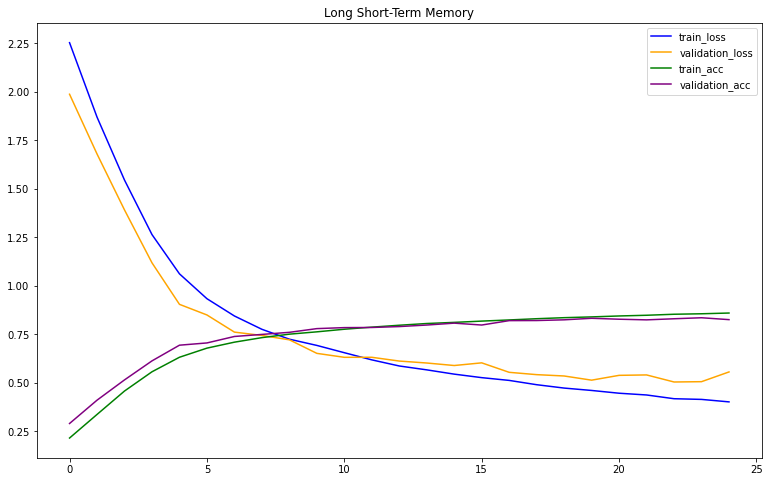

In [19]:
plt.figure(figsize=(13, 8))
plt.plot(history.history['loss'], label='train_loss',color='blue')
plt.plot(history.history['val_loss'], label='validation_loss',color='orange')
plt.plot(history.history['acc'], label='train_acc',color='green')
plt.plot(history.history['val_acc'], label='validation_acc',color='purple')
plt.title('Long Short-Term Memory')

plt.legend()

In [22]:
x_label=["LSTM","CNN"]
y_label=range(0,100)

sns.barplot(x = x_label, y = y_label, ci = None)
plt.show()

AttributeError: 'bool' object has no attribute 'all'